<a href="https://colab.research.google.com/github/gitaglra/Data-Modeling/blob/main/Random_Forest_Classification_for_Sales_Department.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA UNDERSTANDING**

## **0. IMPORT PACKAGES & LIBRARY**

In [ ]:
# Import Packages
import math
from collections import Counter, defaultdict
from functools import partial
from pprint import pprint
from time import time


import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, \
                            classification_report, accuracy_score, \
                            recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, MiniBatchKMeans
%matplotlib inline

plt.style.use("fivethirtyeight")

## **1. IMPORT DATASET**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_order = pd.read_csv('/content/drive/MyDrive/Final Project/Join Table Dataset Primary Secondary.csv')

In [ ]:
df_order.head()

,id,order_id,user_id,gender,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item
0,8,4,1,M,22984,23,Cancelled,2020-02-10 17:22:36,NaN,NaN,NaN,30.000000,2
1,7,4,1,M,27828,21,Cancelled,2020-02-10 15:16:21,NaN,NaN,NaN,47.040001,2
2,6,3,1,M,28048,19,Processing,2022-05-14 15:41:18,NaN,NaN,NaN,47.990002,1
3,5,2,1,M,27061,15,Processing,2021-11-30 16:02:04,NaN,NaN,NaN,42.000000,1
4,4,1,1,M,27726,13,Complete,2019-07-19 15:45:02,2019-07-18 07:58:00,2019-07-22 10:36:00,NaN,49.990002,4


In [ ]:
df_order.shape

(180508, 13)

In [ ]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180508 entries, 0 to 180507
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 180508 non-null  int64  
 1   order_id           180508 non-null  int64  
 2   user_id            180508 non-null  int64  
 3   gender             180508 non-null  object 
 4   product_id         180508 non-null  int64  
 5   inventory_item_id  180508 non-null  int64  
 6   status             180508 non-null  object 
 7   created_at         180508 non-null  object 
 8   shipped_at         117502 non-null  object 
 9   delivered_at       63035 non-null   object 
 10  returned_at        17752 non-null   object 
 11  sale_price         180508 non-null  float64
 12  num_of_item        180508 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 17.9+ MB


## **2. DESCRIPTIVE STATISTICS OF DATASET**

In [ ]:
df_order['created_at'] = pd.to_datetime(df_order['created_at']).dt.date
df_order['shipped_at'] = pd.to_datetime(df_order['shipped_at']).dt.date
df_order['delivered_at'] = pd.to_datetime(df_order['delivered_at']).dt.date
df_order['returned_at'] = pd.to_datetime(df_order['returned_at']).dt.date

In [ ]:
df_order['created_at'] = pd.to_datetime(df_order['created_at'])
df_order['shipped_at'] = pd.to_datetime(df_order['shipped_at'])
df_order['delivered_at'] = pd.to_datetime(df_order['delivered_at'])
df_order['returned_at'] = pd.to_datetime(df_order['returned_at'])

In [ ]:
#Memeriksa Jenis Variabel
numerical_features = df_order.select_dtypes(include = "number").columns.tolist()
categorical_features = df_order.select_dtypes(include = "object").columns.tolist()

print("Numerical features:")
pprint(numerical_features)
print()
print("Categorical features:")
pprint(categorical_features, compact = True)

Numerical features:
['id',
 'order_id',
 'user_id',
 'product_id',
 'inventory_item_id',
 'sale_price',
 'num_of_item']

Categorical features:
['gender', 'status']


In [ ]:
df_order.head(3)

,id,order_id,user_id,gender,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item
0,8,4,1,M,22984,23,Cancelled,2020-02-10,NaT,NaT,NaT,30.000000,2
1,7,4,1,M,27828,21,Cancelled,2020-02-10,NaT,NaT,NaT,47.040001,2
2,6,3,1,M,28048,19,Processing,2022-05-14,NaT,NaT,NaT,47.990002,1


In [ ]:
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180508 entries, 0 to 180507
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 180508 non-null  int64         
 1   order_id           180508 non-null  int64         
 2   user_id            180508 non-null  int64         
 3   gender             180508 non-null  object        
 4   product_id         180508 non-null  int64         
 5   inventory_item_id  180508 non-null  int64         
 6   status             180508 non-null  object        
 7   created_at         180508 non-null  datetime64[ns]
 8   shipped_at         117502 non-null  datetime64[ns]
 9   delivered_at       63035 non-null   datetime64[ns]
 10  returned_at        17752 non-null   datetime64[ns]
 11  sale_price         180508 non-null  float64       
 12  num_of_item        180508 non-null  int64         
dtypes: datetime64[ns](4), float64(1), int64(6), 

In [ ]:
df_order[categorical_features].describe().T #T untuk transpose table

,count,unique,top,freq
gender,180508,2,M,90501
status,180508,5,Shipped,54467


In [ ]:
df_order[numerical_features].describe().T #T untuk transpose table

,count,mean,std,min,25%,50%,75%,max
id,180508.0,90254.500000,52108.315533,1.00,45127.75,90254.500000,135381.250000,180508.0
order_id,180508.0,62408.024420,35991.857094,1.00,31249.75,62520.000000,93647.000000,124512.0
user_id,180508.0,50171.351602,28839.688216,1.00,25249.75,50273.000000,75175.000000,100000.0
product_id,180508.0,15290.370105,8405.434843,1.00,8050.00,16029.000000,22547.000000,29120.0
inventory_item_id,180508.0,243722.590096,140711.306992,2.00,121863.25,243832.500000,365533.000000,487394.0
sale_price,180508.0,59.799867,65.844662,0.02,24.90,39.990002,69.949997,999.0
num_of_item,180508.0,1.894021,1.058109,1.00,1.00,2.000000,2.000000,4.0


## **3. EXPLORATORY DATA ANALYSIS**

**Data Dictionary**:

| Column | Data Type | Description |
| ------ | ---- ---- | ----------- |
| `id` | INT | ID order items |
| `order_id` | INT | ID Order (tabel) |
| `user_id` | INT | ID User (tabel) |
| `product_id` | INT | ID Product (tabel) |
| `inventory_item_id` | INT | ID Inventory items |
| `status` | STRING | Status Order |
| `created_at` | TIMESTAMP | Waktu yang dicatat saat order dipesan |
| `shipped_at` | TIMESTAMP | Waktu yang dicatat saat order dikemas |
| `delivered_at` | TIMESTAMP | Waktu yang dicatat saat order dikirim |
| `returned_at` | TIMESTAMP | Waktu yang dicatat saat order dikembalikan oleh user |
| `sale_price` | FLOAT | Harga jual barang ($) |

### 3.1. Basic Information from Dataset

In [ ]:
# Nama Kolom / Variabel dari Dataset
df_order.columns

Index(['id', 'order_id', 'user_id', 'gender', 'product_id',
       'inventory_item_id', 'status', 'created_at', 'shipped_at',
       'delivered_at', 'returned_at', 'sale_price', 'num_of_item'],
      dtype='object')

In [ ]:
# Jumlah Baris & Kolom Dataset
df_order.shape

(180508, 13)

In [ ]:
# Nama Kolom Variabel Kategorik
df_order[categorical_features].columns

Index(['gender', 'status'], dtype='object')

In [ ]:
# Nama Kolom Variabel Numerik
df_order[numerical_features].columns

Index(['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
       'sale_price', 'num_of_item'],
      dtype='object')

In [ ]:
# Jumlah Data Unik pada Variabel KAtegorik
df_order[categorical_features].nunique()

gender    2
status    5
dtype: int64

In [ ]:
#Jumlah User Berdasarkan Gender
df_order.gender.value_counts()

M    90501
F    90007
Name: gender, dtype: int64

In [ ]:
#Jumlah User Berdasarkan Status
df_order.status.value_counts()

Shipped       54467
Complete      45283
Processing    36225
Cancelled     26781
Returned      17752
Name: status, dtype: int64

In [ ]:
# Info Dataset
df_order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180508 entries, 0 to 180507
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 180508 non-null  int64         
 1   order_id           180508 non-null  int64         
 2   user_id            180508 non-null  int64         
 3   gender             180508 non-null  object        
 4   product_id         180508 non-null  int64         
 5   inventory_item_id  180508 non-null  int64         
 6   status             180508 non-null  object        
 7   created_at         180508 non-null  datetime64[ns]
 8   shipped_at         117502 non-null  datetime64[ns]
 9   delivered_at       63035 non-null   datetime64[ns]
 10  returned_at        17752 non-null   datetime64[ns]
 11  sale_price         180508 non-null  float64       
 12  num_of_item        180508 non-null  int64         
dtypes: datetime64[ns](4), float64(1), int64(6), 

### 3.2. Missing Values

In [ ]:
# Pendeteksian Missing Values
df_order.isnull().sum()

id                        0
order_id                  0
user_id                   0
gender                    0
product_id                0
inventory_item_id         0
status                    0
created_at                0
shipped_at            63006
delivered_at         117473
returned_at          162756
sale_price                0
num_of_item               0
dtype: int64

### 3.3. Outliers

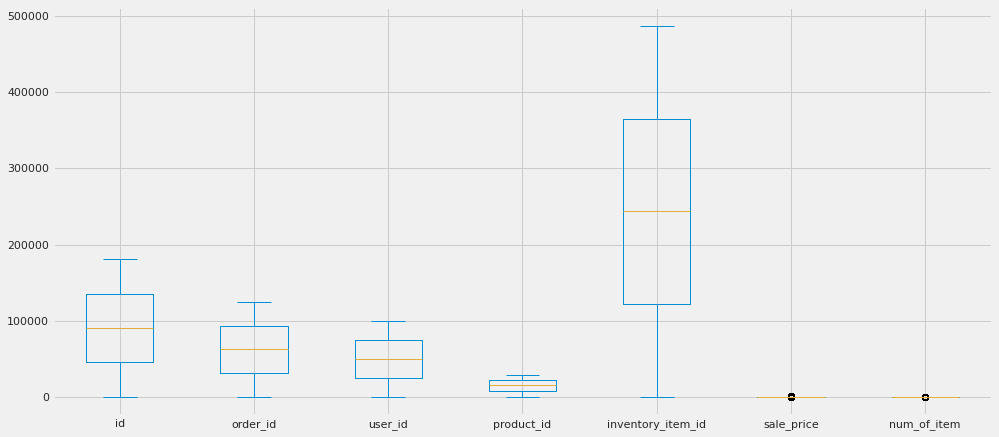

In [ ]:
# Pendeteksian Outliers
df_order[numerical_features].plot(kind = "box", figsize = (15, 7))
plt.grid(True)
plt.show()

### 3.4. Korelasi

In [ ]:
# Pendeteksian Korelasi
df_order.corr()

,id,order_id,user_id,product_id,inventory_item_id,sale_price,num_of_item
id,1.000000,0.999998,0.999996,-0.001537,1.000000,-0.003282,0.009392
order_id,0.999998,1.000000,0.999997,-0.001550,0.999997,-0.003280,0.009375
user_id,0.999996,0.999997,1.000000,-0.001547,0.999997,-0.003285,0.009371
product_id,-0.001537,-0.001550,-0.001547,1.000000,-0.001537,-0.002226,0.004863
inventory_item_id,1.000000,0.999997,0.999997,-0.001537,1.000000,-0.003282,0.009392
sale_price,-0.003282,-0.003280,-0.003285,-0.002226,-0.003282,1.000000,0.000763
num_of_item,0.009392,0.009375,0.009371,0.004863,0.009392,0.000763,1.000000


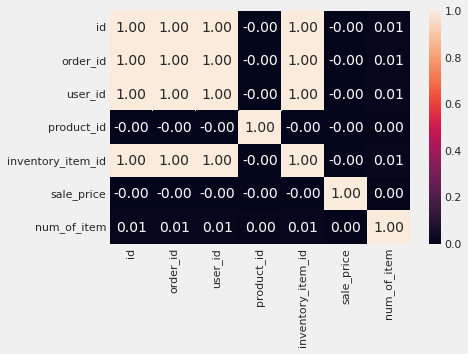

In [ ]:
# Heatmap
sns.heatmap(df_order.corr(), annot = True, fmt = ".2f")
plt.show()

### 3.5. Visualisasi

In [ ]:
# Pembentukan Fungsi Visualisasi
def plot_count(x, data = df_order, palette = None, figsize = (12, 6)):
    column_order = data[x].value_counts().index

    plt.figure(figsize = figsize)
    sns.countplot(
        x = x, data = data, order = column_order,
        palette = palette
    )
    plt.grid(False)
    plt.show()

#### 3.5.1. Gender

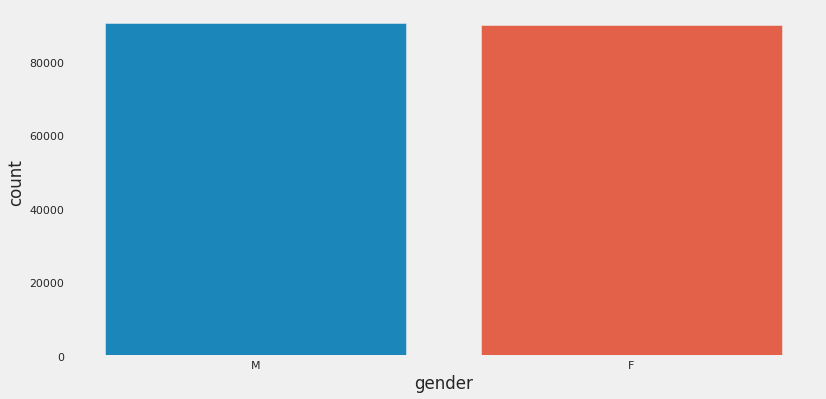

In [ ]:
gender_ = df_order["gender"].value_counts().index
plot_count("gender")

#### 3.5.2. Status

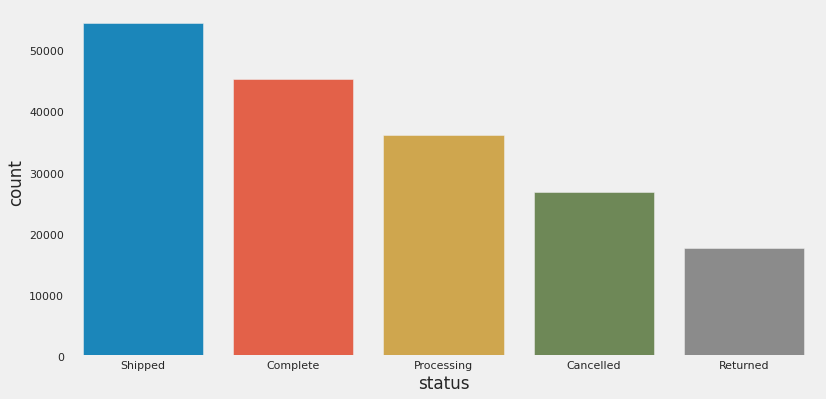

In [ ]:
status_order = df_order["status"].value_counts().index
plot_count("status")

# **DATA PREP**

## **1. DATA CLEANSING**

### 1.1. Visualisasi

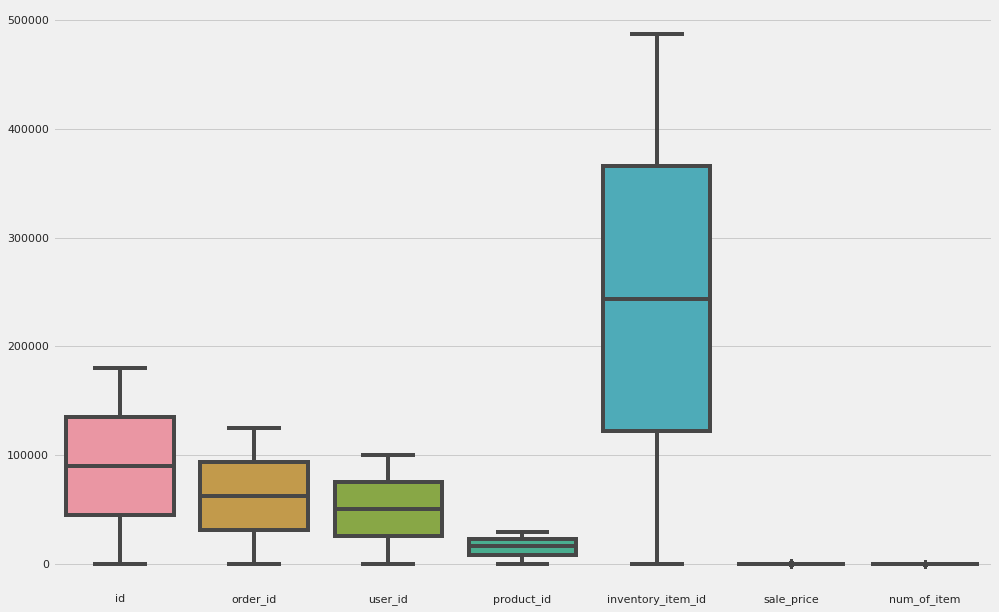

In [ ]:
# Deteksi Outliers
fig, ax = plt.subplots(figsize = (15,10)) #membuat frame/figure
sns.boxplot(data = df_order)

Penanganan outlier dapat digunakan beberapa cara bergantung pada kasus yang ada. 


1.   Outlier diperlukan jika tujuan analisis adalah untuk mengetahui perubahan yang signifikan pada data
2.   Outlier harus dibuang jika kita tidak mempunyai data pembenar atau mengganggu dari segi summary statistics atau analisis kedepannya.

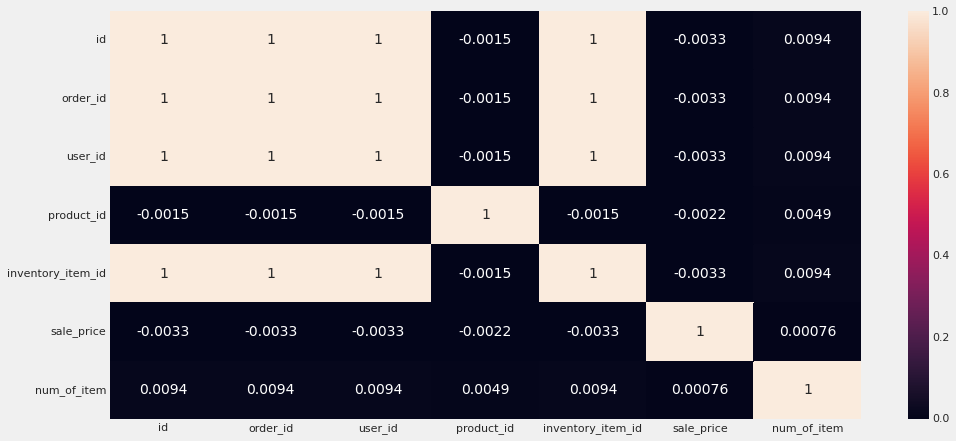

In [ ]:
# Melihat Korelasi antar Variabel
plt.figure(figsize=(15, 7))
sns.heatmap(df_order.corr(), annot=True)

### 1.2. Handling Outlier

**Inter Quartile Range**
Menghapus outlier bisa menggunakan batas atas dan bawah dari 1.5*IQR, sehingga semua nilai yang ada diluar batas tersebut akan dihapus.

Rumus yang digunakan:


*   IQR = Q3-Q1
*   Batas Atas = Q3+1.5*IQR
*   Batas Bawah = Q1-1.5*IQR

#### 1.2.1. Sale Price

In [ ]:
# Cari Q1, Q3, dan interquartile range
Q1 = df_order['sale_price'].quantile(q = .25)
Q3 = df_order['sale_price'].quantile(q = .75)
IQR = Q3 - Q1 #IQR=Q3-Q1 atau bisa menggunakan stats.iqr dari scipy

# Mengambil nilai antara 1.5*IQR dari Q1 dan Q3 aja
print('Shape awal:', df_order.shape)
df_order = df_order[~((df_order['sale_price'] < (Q1-1.5*IQR)) | (df_order['sale_price'] > (Q3+1.5*IQR)))]
print('Shape akhir:', df_order.shape)

Shape awal: (180508, 13)
Shape akhir: (164631, 13)


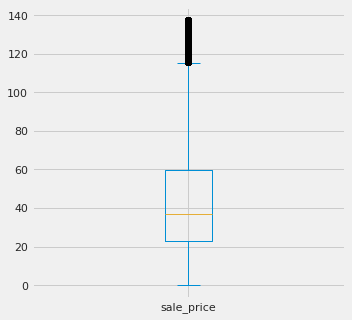

In [ ]:
# Visualisasi Sale Price
df_order['sale_price'].plot(kind = 'box',
                            figsize = (5,5))
plt.grid(True)
plt.show()

#### 1.2.2. Number of Item

In [ ]:
# Cari Q1, Q3, dan interquartile range
Q1 = df_order['num_of_item'].quantile(q = .25)
Q3 = df_order['num_of_item'].quantile(q = .75)
IQR = Q3 - Q1 #IQR=Q3-Q1 atau bisa menggunakan stats.iqr dari scipy

# Mengambil nilai antara 1.5*IQR dari Q1 dan Q3 aja
print('Shape awal:', df_order.shape)
df_order = df_order[~((df_order['num_of_item'] < (Q1-1.5*IQR)) | (df_order['num_of_item'] > (Q3+1.5*IQR)))]
print('Shape akhir:', df_order.shape)

Shape awal: (164631, 13)
Shape akhir: (142211, 13)


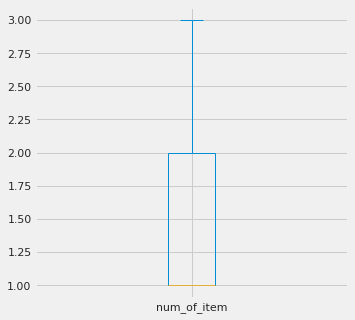

In [ ]:
# Visualisasi Number of Items
df_order['num_of_item'].plot(kind = 'box',
                            figsize = (5,5))
plt.grid(True)
plt.show()

## **2. DATA TYPE**

In [ ]:
df_order['order_id'] = df_order.order_id.astype("int")

In [ ]:
# Filter data transaksi 
df_order.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142211 entries, 0 to 180507
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   id                 142211 non-null  int64         
 1   order_id           142211 non-null  int64         
 2   user_id            142211 non-null  int64         
 3   gender             142211 non-null  object        
 4   product_id         142211 non-null  int64         
 5   inventory_item_id  142211 non-null  int64         
 6   status             142211 non-null  object        
 7   created_at         142211 non-null  datetime64[ns]
 8   shipped_at         92369 non-null   datetime64[ns]
 9   delivered_at       49667 non-null   datetime64[ns]
 10  returned_at        14045 non-null   datetime64[ns]
 11  sale_price         142211 non-null  float64       
 12  num_of_item        142211 non-null  int64         
dtypes: datetime64[ns](4), float64(1), int64(6), 

In [ ]:
df_order.isna().sum()

id                        0
order_id                  0
user_id                   0
gender                    0
product_id                0
inventory_item_id         0
status                    0
created_at                0
shipped_at            49842
delivered_at          92544
returned_at          128166
sale_price                0
num_of_item               0
dtype: int64

In [ ]:
df_order.head(3)

,id,order_id,user_id,gender,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item
0,8,4,1,M,22984,23,Cancelled,2020-02-10,NaT,NaT,NaT,30.000000,2
1,7,4,1,M,27828,21,Cancelled,2020-02-10,NaT,NaT,NaT,47.040001,2
2,6,3,1,M,28048,19,Processing,2022-05-14,NaT,NaT,NaT,47.990002,1


In [ ]:
num_users = df_order.user_id.nunique()
num_order = df_order.order_id.nunique()
 
print("Number of unique users:", num_users)
print("Number of order:", num_order)

Number of unique users: 74134
Number of order: 110508


In [ ]:
df_by_day = df_order.groupby("created_at")
df_by_month = df_order.groupby(df_order.created_at.dt.month)
df_by_users = df_order.groupby("user_id")
df_by_order = df_order.groupby("order_id")

## **3. VISUALIZATION**

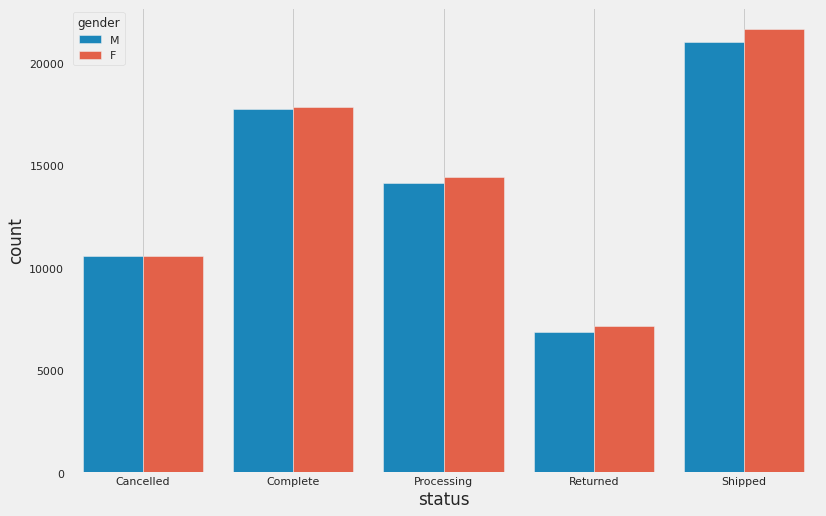

In [ ]:
# Membuat visualisasi berdasarkan status terhadap gender
plt.figure(figsize=(12, 8))
sns.countplot(
    x = 'status',
    data = df_order,
    hue = 'gender',
    order = sorted(df_order.status.unique()))
plt.grid()
plt.show()

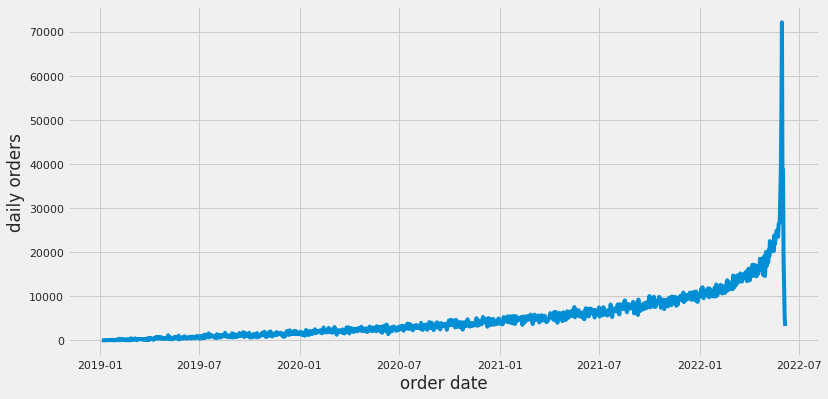

In [ ]:
daily_order = df_by_day.agg(daily_order = pd.NamedAgg(column = "sale_price",
                                                      aggfunc="sum")).reset_index()
 
plt.figure(figsize = (12, 6))
sns.lineplot(x = "created_at", y = "daily_order", data = daily_order)
plt.xlabel("order date")
plt.ylabel("daily orders")
plt.show()

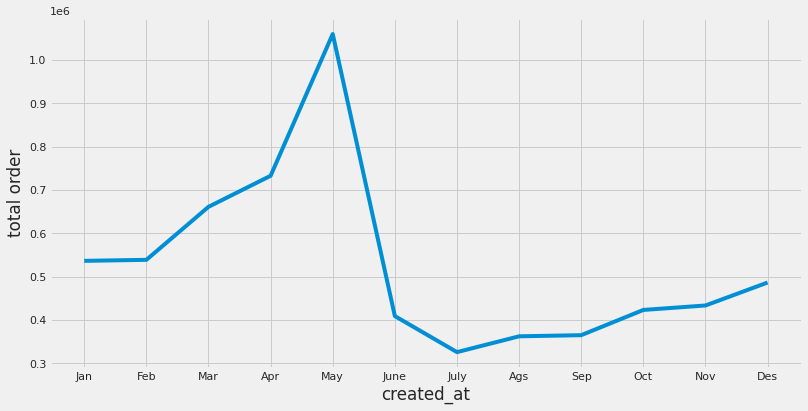

In [ ]:
monthly_order = df_by_month.agg(monthly_order = pd.NamedAgg(column = "sale_price",
                                                            aggfunc = "sum")).reset_index()
 
plt.figure(figsize = (12, 6))
sns.lineplot(x = "created_at", y = "monthly_order", data = monthly_order)
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12], ["Jan","Feb","Mar","Apr","May","June", 
                                          "July", "Ags", "Sep","Oct","Nov","Des"])
plt.ylabel("total order")
plt.show()

## **4. NEW VARIABLES**

In [ ]:
df_users_agg = df_by_users.agg(
    total_repeat_orders = pd.NamedAgg(
        column = "order_id", aggfunc = lambda x : len(list(x))
    ),
    count_repeat_orders = pd.NamedAgg(
        column = "order_id", aggfunc = lambda x : len(set(x))
    ),
    total_spending = pd.NamedAgg(
        column = "sale_price", aggfunc = lambda x : sum(x)
    ),
    avg_spending = pd.NamedAgg(
        column = "sale_price", aggfunc = lambda x : np.mean(x)
    ),
    count_buying_day = pd.NamedAgg(
        column = "created_at", aggfunc = lambda x : len(set(x))
    )
).reset_index()

In [ ]:
df_users_agg.head(3)

,user_id,total_repeat_orders,count_repeat_orders,total_spending,avg_spending,count_buying_day
0,1,4,3,167.030003,41.757501,3
1,3,2,2,32.990000,16.495000,2
2,4,2,1,141.789997,70.894999,1


In [ ]:
#Summary statistics dari transaksi users
df_users_agg.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
user_id,74134.0,50024.728,28821.768,1.00,25092.75,50018.500,74976.75,100000.00
total_repeat_orders,74134.0,1.918,1.215,1.00,1.00,2.000,2.00,11.00
count_repeat_orders,74134.0,1.491,0.794,1.00,1.00,1.000,2.00,4.00
total_spending,74134.0,85.495,67.598,0.49,34.99,67.325,118.00,529.97
avg_spending,74134.0,44.578,24.674,0.49,26.13,39.990,57.30,137.50
count_buying_day,74134.0,1.812,1.113,1.00,1.00,1.000,2.00,9.00


In [ ]:
df_users_agg.head(5)

,user_id,total_repeat_orders,count_repeat_orders,total_spending,avg_spending,count_buying_day
0,1,4,3,167.030003,41.757501,3
1,3,2,2,32.990000,16.495000,2
2,4,2,1,141.789997,70.894999,1
3,6,1,1,64.900002,64.900002,1
4,7,1,1,73.709999,73.709999,1


# **MODELING**

## **1. MODEL PREP**

### Mengubah Values Variable "status"

1.   `Processing` to `Complete`
2.   `Shipped` to `Complete`
3.   `Returned` to `Cancelled`



In [ ]:
# 1. Mengubah processing ke complete
status_complete = df_order['status']
status_complete = status_complete.replace('Processing', 'Complete')
status_complete

0         Cancelled
1         Cancelled
2          Complete
3          Complete
8          Complete
            ...    
180503    Cancelled
180504     Complete
180505      Shipped
180506     Complete
180507      Shipped
Name: status, Length: 142211, dtype: object

In [ ]:
# 1.1 Menghapus variabel status yang lama berisi 5 unique values menjadi 4
dropdata = df_order.drop(['status'], axis = 1)
dropdata

,id,order_id,user_id,gender,product_id,inventory_item_id,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item
0,8,4,1,M,22984,23,2020-02-10,NaT,NaT,NaT,30.000000,2
1,7,4,1,M,27828,21,2020-02-10,NaT,NaT,NaT,47.040001,2
2,6,3,1,M,28048,19,2022-05-14,NaT,NaT,NaT,47.990002,1
3,5,2,1,M,27061,15,2021-11-30,NaT,NaT,NaT,42.000000,1
8,10,6,3,M,18499,28,2021-07-31,NaT,NaT,NaT,13.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
180503,180502,124507,99997,F,5262,487379,2020-03-03,NaT,NaT,NaT,36.090000,2
180504,180505,124509,99998,F,5583,487386,2022-02-01,NaT,NaT,NaT,44.000000,1
180505,180506,124510,99999,M,17518,487388,2022-05-10,2022-05-11,NaT,NaT,75.000000,1
180506,180508,124512,100000,M,20039,487394,2021-06-08,NaT,NaT,NaT,49.880001,1


In [ ]:
# 1.2 Merge dropdata dan status_complete
df_sales = pd.concat([dropdata, status_complete], axis = 1)
df_sales

,id,order_id,user_id,gender,product_id,inventory_item_id,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item,status
0,8,4,1,M,22984,23,2020-02-10,NaT,NaT,NaT,30.000000,2,Cancelled
1,7,4,1,M,27828,21,2020-02-10,NaT,NaT,NaT,47.040001,2,Cancelled
2,6,3,1,M,28048,19,2022-05-14,NaT,NaT,NaT,47.990002,1,Complete
3,5,2,1,M,27061,15,2021-11-30,NaT,NaT,NaT,42.000000,1,Complete
8,10,6,3,M,18499,28,2021-07-31,NaT,NaT,NaT,13.000000,1,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180503,180502,124507,99997,F,5262,487379,2020-03-03,NaT,NaT,NaT,36.090000,2,Cancelled
180504,180505,124509,99998,F,5583,487386,2022-02-01,NaT,NaT,NaT,44.000000,1,Complete
180505,180506,124510,99999,M,17518,487388,2022-05-10,2022-05-11,NaT,NaT,75.000000,1,Shipped
180506,180508,124512,100000,M,20039,487394,2021-06-08,NaT,NaT,NaT,49.880001,1,Complete


In [ ]:
# 2. Mengubah shipped ke complete
status_complete = df_sales['status'].replace('Shipped', 'Complete')
status_complete

0         Cancelled
1         Cancelled
2          Complete
3          Complete
8          Complete
            ...    
180503    Cancelled
180504     Complete
180505     Complete
180506     Complete
180507     Complete
Name: status, Length: 142211, dtype: object

In [ ]:
# 2.1 Menghapus variabel status yang lama berisi 4 unique values menjadi 3
dropdata2 = df_sales.drop(['status'], axis = 1)
dropdata2

,id,order_id,user_id,gender,product_id,inventory_item_id,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item
0,8,4,1,M,22984,23,2020-02-10,NaT,NaT,NaT,30.000000,2
1,7,4,1,M,27828,21,2020-02-10,NaT,NaT,NaT,47.040001,2
2,6,3,1,M,28048,19,2022-05-14,NaT,NaT,NaT,47.990002,1
3,5,2,1,M,27061,15,2021-11-30,NaT,NaT,NaT,42.000000,1
8,10,6,3,M,18499,28,2021-07-31,NaT,NaT,NaT,13.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
180503,180502,124507,99997,F,5262,487379,2020-03-03,NaT,NaT,NaT,36.090000,2
180504,180505,124509,99998,F,5583,487386,2022-02-01,NaT,NaT,NaT,44.000000,1
180505,180506,124510,99999,M,17518,487388,2022-05-10,2022-05-11,NaT,NaT,75.000000,1
180506,180508,124512,100000,M,20039,487394,2021-06-08,NaT,NaT,NaT,49.880001,1


In [ ]:
# 2.2 Merge dropdata2 dan status_complete
df_sales2 = pd.concat([dropdata2, status_complete], axis = 1)
df_sales2

,id,order_id,user_id,gender,product_id,inventory_item_id,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item,status
0,8,4,1,M,22984,23,2020-02-10,NaT,NaT,NaT,30.000000,2,Cancelled
1,7,4,1,M,27828,21,2020-02-10,NaT,NaT,NaT,47.040001,2,Cancelled
2,6,3,1,M,28048,19,2022-05-14,NaT,NaT,NaT,47.990002,1,Complete
3,5,2,1,M,27061,15,2021-11-30,NaT,NaT,NaT,42.000000,1,Complete
8,10,6,3,M,18499,28,2021-07-31,NaT,NaT,NaT,13.000000,1,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180503,180502,124507,99997,F,5262,487379,2020-03-03,NaT,NaT,NaT,36.090000,2,Cancelled
180504,180505,124509,99998,F,5583,487386,2022-02-01,NaT,NaT,NaT,44.000000,1,Complete
180505,180506,124510,99999,M,17518,487388,2022-05-10,2022-05-11,NaT,NaT,75.000000,1,Complete
180506,180508,124512,100000,M,20039,487394,2021-06-08,NaT,NaT,NaT,49.880001,1,Complete


In [ ]:
# 3. Mengubah returned ke cancelled
status_cancelled = df_sales2['status'].replace('Returned', 'Cancelled')
status_cancelled

0         Cancelled
1         Cancelled
2          Complete
3          Complete
8          Complete
            ...    
180503    Cancelled
180504     Complete
180505     Complete
180506     Complete
180507     Complete
Name: status, Length: 142211, dtype: object

In [ ]:
# 3.1 Menghapus variabel status yang lama berisi 3 unique values menjadi 2
dropdata3 = df_sales2.drop(['status'], axis = 1)
dropdata3

,id,order_id,user_id,gender,product_id,inventory_item_id,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item
0,8,4,1,M,22984,23,2020-02-10,NaT,NaT,NaT,30.000000,2
1,7,4,1,M,27828,21,2020-02-10,NaT,NaT,NaT,47.040001,2
2,6,3,1,M,28048,19,2022-05-14,NaT,NaT,NaT,47.990002,1
3,5,2,1,M,27061,15,2021-11-30,NaT,NaT,NaT,42.000000,1
8,10,6,3,M,18499,28,2021-07-31,NaT,NaT,NaT,13.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...
180503,180502,124507,99997,F,5262,487379,2020-03-03,NaT,NaT,NaT,36.090000,2
180504,180505,124509,99998,F,5583,487386,2022-02-01,NaT,NaT,NaT,44.000000,1
180505,180506,124510,99999,M,17518,487388,2022-05-10,2022-05-11,NaT,NaT,75.000000,1
180506,180508,124512,100000,M,20039,487394,2021-06-08,NaT,NaT,NaT,49.880001,1


In [ ]:
# 3.2 Merge dropdata3 dan status_complete
df_sales3 = pd.concat([dropdata3, status_cancelled], axis = 1)
df_sales3

,id,order_id,user_id,gender,product_id,inventory_item_id,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item,status
0,8,4,1,M,22984,23,2020-02-10,NaT,NaT,NaT,30.000000,2,Cancelled
1,7,4,1,M,27828,21,2020-02-10,NaT,NaT,NaT,47.040001,2,Cancelled
2,6,3,1,M,28048,19,2022-05-14,NaT,NaT,NaT,47.990002,1,Complete
3,5,2,1,M,27061,15,2021-11-30,NaT,NaT,NaT,42.000000,1,Complete
8,10,6,3,M,18499,28,2021-07-31,NaT,NaT,NaT,13.000000,1,Complete
...,...,...,...,...,...,...,...,...,...,...,...,...,...
180503,180502,124507,99997,F,5262,487379,2020-03-03,NaT,NaT,NaT,36.090000,2,Cancelled
180504,180505,124509,99998,F,5583,487386,2022-02-01,NaT,NaT,NaT,44.000000,1,Complete
180505,180506,124510,99999,M,17518,487388,2022-05-10,2022-05-11,NaT,NaT,75.000000,1,Complete
180506,180508,124512,100000,M,20039,487394,2021-06-08,NaT,NaT,NaT,49.880001,1,Complete


### Encoding Categorical Features

In [ ]:
# Categorical Encoding for Gender
labelencoder = LabelEncoder()
df_sales3['gender'] = labelencoder.fit_transform(df_sales3['gender'])
df_sales3 = pd.get_dummies(df_sales3, columns=['gender'])
df_sales3

,id,order_id,user_id,product_id,inventory_item_id,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item,status,gender_0,gender_1
0,8,4,1,22984,23,2020-02-10,NaT,NaT,NaT,30.000000,2,Cancelled,0,1
1,7,4,1,27828,21,2020-02-10,NaT,NaT,NaT,47.040001,2,Cancelled,0,1
2,6,3,1,28048,19,2022-05-14,NaT,NaT,NaT,47.990002,1,Complete,0,1
3,5,2,1,27061,15,2021-11-30,NaT,NaT,NaT,42.000000,1,Complete,0,1
8,10,6,3,18499,28,2021-07-31,NaT,NaT,NaT,13.000000,1,Complete,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180503,180502,124507,99997,5262,487379,2020-03-03,NaT,NaT,NaT,36.090000,2,Cancelled,1,0
180504,180505,124509,99998,5583,487386,2022-02-01,NaT,NaT,NaT,44.000000,1,Complete,1,0
180505,180506,124510,99999,17518,487388,2022-05-10,2022-05-11,NaT,NaT,75.000000,1,Complete,0,1
180506,180508,124512,100000,20039,487394,2021-06-08,NaT,NaT,NaT,49.880001,1,Complete,0,1


In [ ]:
# Categorical Encoding for Status
df_sales3['status'] = labelencoder.fit_transform(df_sales3['status'])
df_sales3 = pd.get_dummies(df_sales3, columns=['status'])
df_sales3

,id,order_id,user_id,product_id,inventory_item_id,created_at,shipped_at,delivered_at,returned_at,sale_price,num_of_item,gender_0,gender_1,status_0,status_1
0,8,4,1,22984,23,2020-02-10,NaT,NaT,NaT,30.000000,2,0,1,1,0
1,7,4,1,27828,21,2020-02-10,NaT,NaT,NaT,47.040001,2,0,1,1,0
2,6,3,1,28048,19,2022-05-14,NaT,NaT,NaT,47.990002,1,0,1,0,1
3,5,2,1,27061,15,2021-11-30,NaT,NaT,NaT,42.000000,1,0,1,0,1
8,10,6,3,18499,28,2021-07-31,NaT,NaT,NaT,13.000000,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180503,180502,124507,99997,5262,487379,2020-03-03,NaT,NaT,NaT,36.090000,2,1,0,1,0
180504,180505,124509,99998,5583,487386,2022-02-01,NaT,NaT,NaT,44.000000,1,1,0,0,1
180505,180506,124510,99999,17518,487388,2022-05-10,2022-05-11,NaT,NaT,75.000000,1,0,1,0,1
180506,180508,124512,100000,20039,487394,2021-06-08,NaT,NaT,NaT,49.880001,1,0,1,0,1


In [ ]:
sales = df_users_agg.merge(df_sales3, how = 'left', on = 'user_id')
sales.drop(columns=['id',
                    'product_id',
                    'inventory_item_id',
                    'created_at',
                    'shipped_at',
                    'delivered_at',
                    'returned_at'], inplace = True)
sales

,user_id,total_repeat_orders,count_repeat_orders,total_spending,avg_spending,count_buying_day,order_id,sale_price,num_of_item,gender_0,gender_1,status_0,status_1
0,1,4,3,167.030003,41.757501,3,4,30.000000,2,0,1,1,0
1,1,4,3,167.030003,41.757501,3,4,47.040001,2,0,1,1,0
2,1,4,3,167.030003,41.757501,3,3,47.990002,1,0,1,0,1
3,1,4,3,167.030003,41.757501,3,2,42.000000,1,0,1,0,1
4,3,2,2,32.990000,16.495000,2,6,13.000000,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
142206,99997,3,2,70.080000,23.360000,3,124507,36.090000,2,1,0,1,0
142207,99998,1,1,44.000000,44.000000,1,124509,44.000000,1,1,0,0,1
142208,99999,1,1,75.000000,75.000000,1,124510,75.000000,1,0,1,0,1
142209,100000,2,2,119.869999,59.934999,2,124512,49.880001,1,0,1,0,1


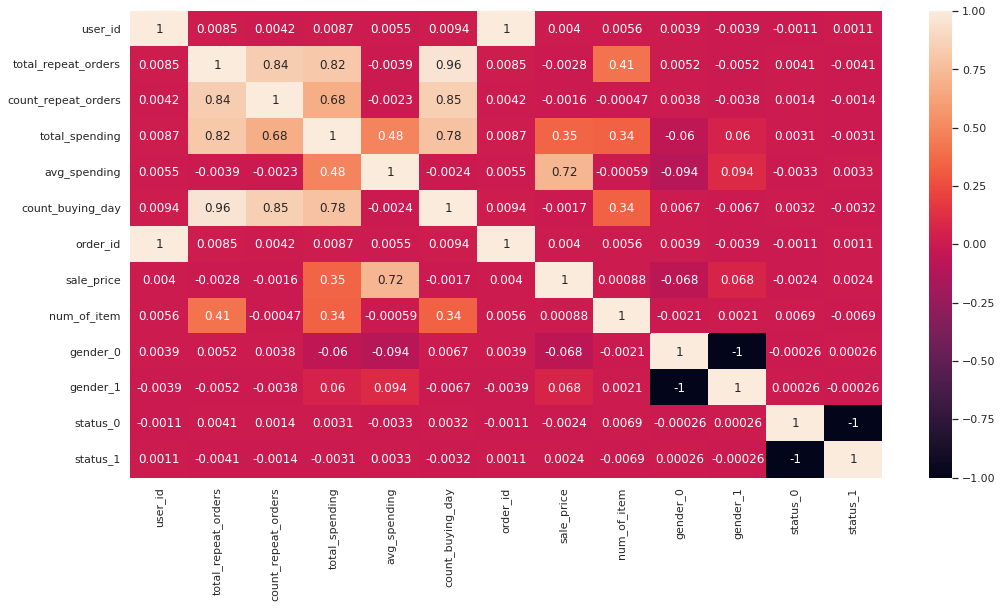

In [ ]:
# Heatmap
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(sales.corr(), annot = True)

### Mendefinisikan Variabel Prediktor (X) & Respon (Y)

In [ ]:
# Variabel Prediktor
X1 = sales[['gender_1']] # 0 = Female, 1 = Male
X2 = sales[['num_of_item']]
X3 = sales[['sale_price']]
X = pd.concat([X1, X2, X3], axis = 1)
X

,gender_1,num_of_item,sale_price
0,1,2,30.000000
1,1,2,47.040001
2,1,1,47.990002
3,1,1,42.000000
4,1,1,13.000000
...,...,...,...
142206,0,2,36.090000
142207,0,1,44.000000
142208,1,1,75.000000
142209,1,1,49.880001


In [ ]:
# Variabel Respon
Y = sales[['status_0']] # 0 = Complete Order, 1 = Cancelled Order
Y

,status_0
0,1
1,1
2,0
3,0
4,0
...,...
142206,1
142207,0
142208,0
142209,0


### Data Splitting

In [ ]:
# Membagi proporsi data train 90% dan data test 10%
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size = .1,
                                                    stratify = Y,
                                                    random_state = 11)

print('training size:', X_train.shape[0])
print('test size:', X_test.shape[0])

training size: 127989
test size: 14222


## **2. MODEL EVALUATION**

### **2.1. RANDOM FOREST**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(class_weight = 'balanced',
                                max_depth = 10,
                                min_samples_split = 20)
model2.fit(X_train,Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=20)

model2 performance on training set
              precision    recall  f1-score   support

           0       0.79      0.60      0.68     96247
           1       0.29      0.51      0.37     31742

    accuracy                           0.57    127989
   macro avg       0.54      0.55      0.52    127989
weighted avg       0.66      0.57      0.60    127989



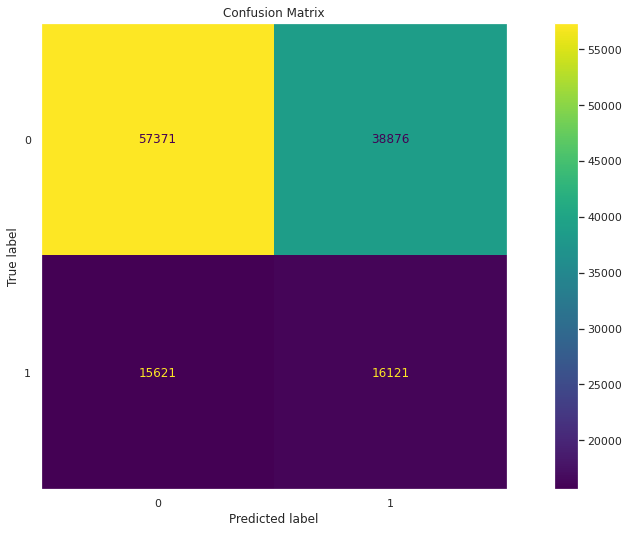

In [ ]:
Y_train_pred = model2.predict(X_train)
print("model2 performance on training set")
print(classification_report(Y_train, Y_train_pred))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(Y_train, Y_train_pred)    # ---> Menjabarkan data dengan Confusion Matrix
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

Insights yang diperoleh dari evaluasi model pada data training adalah:
* semua **evaluation metrics sangat bagus**, mulai dari **accuracy**, **precision**, **recall**, dan **f1-score**
* dari **31,742 data yang berlabel `1` atau `cancelled`**, model gagal memprediksi **15621 data** dengan benar (**false negative**). Ini berarti, ada **15621** user yang seharusnya memiliki riwayat cancelled order, tapi model mengklasifikan mereka sebagai user dengan nihil riwayat cancelled order.

model1 performance on test set
              precision    recall  f1-score   support

           0       0.75      0.57      0.65     10695
           1       0.25      0.44      0.32      3527

    accuracy                           0.54     14222
   macro avg       0.50      0.50      0.48     14222
weighted avg       0.63      0.54      0.57     14222



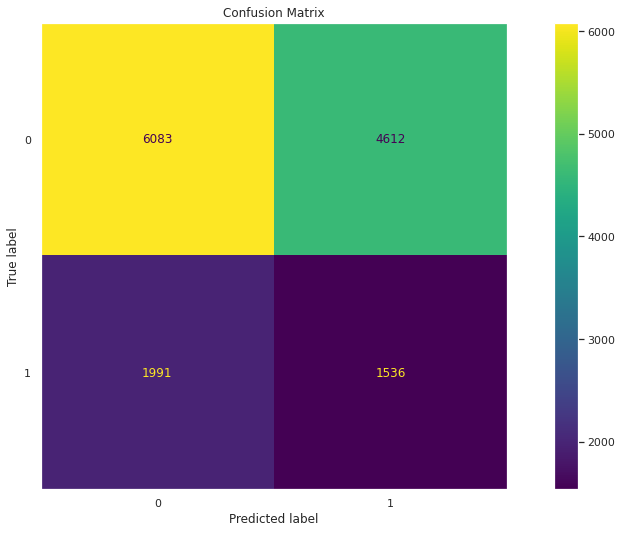

In [ ]:
Y_test_pred = model2.predict(X_test)
print("model1 performance on test set")
print(classification_report(Y_test, Y_test_pred))

# Visualisasikan Confusion Matrix
ConfusionMatrixDisplay.from_predictions(Y_test, Y_test_pred)    # ---> Menjabarkan data dengan Confusion Matrix
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

Insights yang diperoleh dari evaluasi model pada data testing adalah:
* semua **evaluation metrics cukup bagus**, mulai dari **accuracy**, **precision**, **recall**, dan **f1-score**
* dari **3,527 data yang berlabel `1` atau `cancelled`**, model gagal memprediksi **1991 data** dengan benar (**false negative**). Ini berarti, ada **1991** user yang seharusnya memiliki riwayat cancelled order, tapi model mengklasifikan mereka sebagai user dengan nihil riwayat cancelled order.